In [ ]:
import pandas as pd
import os
from openpyxl import load_workbook

# 定义目录路径
directory = "/Users/wanshiqing/Desktop/python_code/CSMAR/data_raw_zip"

# 定义需要提取的列
required_columns = [
    '负债合计', '资产总计', '流动负债合计', '长期负债合计', 
    '期末现金及现金等价物余额', '净利润', '所有者权益合计',
    '短期借款', '长期借款', '股权集中度1', '股权集中度9',
    '首次上市日期', '行业代码'
]

# 初始化一个空的DataFrame用于存储最终结果
merged_df = pd.DataFrame()

# 遍历目录下所有Excel文件
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(directory, filename)
        
        # 检查文件是否有效
        try:
            # 使用openpyxl加载工作簿获取第一行作为列名
            wb = load_workbook(file_path, read_only=True)
            sheet = wb.active
            first_row = [cell.value for cell in sheet[1]]
            wb.close()
            
            # 读取Excel文件，使用第一行作为列名
            df = pd.read_excel(file_path, header=0)
            
            # 检查必需的列是否存在
            if not all(col in df.columns for col in ['证券代码', '时间']):
                print(f"跳过 {filename}: 缺少'证券代码'或'时间'列")
                continue
                
            # 筛选需要的列（只保留存在的列）
            available_cols = [col for col in required_columns if col in df.columns]
            cols_to_keep = ['证券代码', '时间'] + available_cols
            
            # 只保留需要的列
            df = df[cols_to_keep]
            
            # 合并数据
            if merged_df.empty:
                merged_df = df
            else:
                merged_df = pd.merge(
                    merged_df, 
                    df, 
                    on=['证券代码', '时间'], 
                    how='outer',
                    suffixes=('', '_dup')
                )
                
                # 处理重复列（保留第一个出现的列）
                for col in df.columns:
                    if col in merged_df.columns and f"{col}_dup" in merged_df.columns:
                        merged_df[col] = merged_df[col].combine_first(merged_df[f"{col}_dup"])
                        merged_df.drop(f"{col}_dup", axis=1, inplace=True)
                        
            print(f"成功合并: {filename}")
            
        except Exception as e:
            print(f"处理 {filename} 时出错: {str(e)}")

# 输出结果信息
print("\n合并完成!")
print(f"总记录数: {len(merged_df)}")
print(f"包含列: {list(merged_df.columns)}")

# 保存结果到新文件
merged_df.to_excel("merged_data.xlsx", index=False)

成功合并: 资产负债表-2000-2024.xlsx
成功合并: CSMAR常用变量-2000-2024.xlsx
成功合并: 上市公司基本信息年度表.xlsx
跳过 上市公司基本信息变更表2000-2024.xlsx: 缺少'证券代码'或'时间'列
成功合并: 利润表-现金流量表-2000-2024.xlsx

合并完成!
总记录数: 145874
包含列: ['证券代码', '时间', '负债合计', '资产总计', '流动负债合计', '长期负债合计', '所有者权益合计', '短期借款', '长期借款', '股权集中度1', '股权集中度9', '首次上市日期', '行业代码', '期末现金及现金等价物余额', '净利润']


In [12]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. 筛选时间 >= 2000 的数据
merged_df = merged_df[merged_df['时间'] >= 2000].copy()

# 2. 计算各项指标（处理分母为0的情况）
# 安全除法函数
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), 
                    where=(b != 0) & (~np.isnan(b)) & (~np.isnan(a)))

# 计算各项比率
merged_df['Lev'] = safe_divide(merged_df['负债合计'], merged_df['资产总计'])
merged_df['SL'] = safe_divide(merged_df['流动负债合计'], merged_df['资产总计'])
merged_df['LL'] = safe_divide(merged_df['长期负债合计'], merged_df['资产总计'])
merged_df['SDR'] = safe_divide(merged_df['流动负债合计'], merged_df['负债合计'])
merged_df['Cash'] = safe_divide(merged_df['期末现金及现金等价物余额'], merged_df['资产总计'])
merged_df['ROA'] = safe_divide(merged_df['净利润'], merged_df['资产总计'])
merged_df['ROE'] = safe_divide(merged_df['净利润'], merged_df['所有者权益合计'])
merged_df['SLoan'] = safe_divide(merged_df['短期借款'], merged_df['资产总计'])
merged_df['LLoan'] = safe_divide(merged_df['长期借款'], merged_df['资产总计'])

# 直接赋值股权集中度
merged_df['Top1'] = merged_df['股权集中度1']
merged_df['HHI5'] = merged_df['股权集中度9']

# 计算Size = ln(资产总计)，添加小常数避免log(0)
merged_df['Size'] = np.log(merged_df['资产总计'] + 1e-6)

# 3. 计算Age（公司年龄）
# 将首次上市日期转换为datetime格式
def convert_date(date_val):
    if isinstance(date_val, str) and len(date_val) == 8:
        return datetime.strptime(date_val, '%Y%m%d')
    elif isinstance(date_val, (int, float)):
        return datetime(int(date_val), 1, 1)  # 处理整数年份
    return pd.NaT

merged_df['首次上市日期'] = merged_df['首次上市日期'].apply(convert_date)

# 计算公司上市年限
today = datetime.now()
merged_df['Age'] = ((today - merged_df['首次上市日期']).dt.days / 365).fillna(0).astype(int)

# 4. 处理离群值（缩尾处理）
# 需要缩尾的变量列表
winsorize_vars = [
    'Lev', 'SL', 'LL', 'SDR', 'Cash', 'ROA', 'ROE', 
    'SLoan', 'LLoan', 'Top1', 'HHI5', 'Size', 'Age'
]

for var in winsorize_vars:
    if var in merged_df.columns:
        # 计算1%和99%分位数
        low = merged_df[var].quantile(0.01)
        high = merged_df[var].quantile(0.99)
        
        # 缩尾处理
        merged_df[var] = merged_df[var].clip(lower=low, upper=high)

# 显示处理结果
print("数据处理完成！")
print(f"处理后数据形状: {merged_df.shape}")
print(f"包含的指标: {winsorize_vars}")
print(f"时间范围: {merged_df['时间'].min()} - {merged_df['时间'].max()}")
print(f"公司上市年限范围: {merged_df['Age'].min()} - {merged_df['Age'].max()} 年")

数据处理完成！
处理后数据形状: (145874, 28)
包含的指标: ['Lev', 'SL', 'LL', 'SDR', 'Cash', 'ROA', 'ROE', 'SLoan', 'LLoan', 'Top1', 'HHI5', 'Size', 'Age']
时间范围: 2000 - 2024
公司上市年限范围: 0 - 0 年


In [13]:
import pandas as pd

# 定义要统计的指标列表
metrics = [
    'Lev', 'SL', 'LL', 'SDR', 'Cash', 'ROA', 'ROE', 
    'SLoan', 'LLoan', 'Top1', 'HHI5', 'Size', 'Age'
]

# 1. 按'时间'分组
grouped = merged_df.groupby('时间')

# 2. 为每个指标计算统计量
# 创建空的DataFrame存储结果
result_df = pd.DataFrame()

# 对每个指标计算统计量
for metric in metrics:
    if metric in merged_df.columns:
        # 计算各种统计量
        stat_df = grouped[metric].agg([
            ('平均值', 'mean'),
            ('中位数', 'median'),
            ('标准差', 'std'),
            ('最小值', 'min'),
            ('最大值', 'max')
        ])
        
        # 重命名列以包含指标名称
        stat_df.columns = [f"{metric}_{col}" for col in stat_df.columns]
        
        # 合并到结果DataFrame
        if result_df.empty:
            result_df = stat_df
        else:
            result_df = result_df.join(stat_df)

# 3. 打印结果表格
# 设置显示选项以展示完整数据
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

print("="*100)
print("按时间分组的指标统计结果:")
print("="*100)
print(result_df)

# 4. 可选：保存结果到Excel文件
result_df.to_excel("time_grouped_statistics.xlsx")
print("\n结果已保存至 'time_grouped_statistics.xlsx'")

# 5. 可选：生成更易读的格式（每个指标单独表格）
print("\n\n按指标分组的详细统计:")
for metric in metrics:
    if metric in merged_df.columns:
        print("\n" + "="*50)
        print(f"{metric} 的年度统计:")
        print("="*50)
        metric_df = grouped[metric].agg(['mean', 'median', 'std', 'min', 'max'])
        metric_df.columns = ['平均值', '中位数', '标准差', '最小值', '最大值']
        print(metric_df)

按时间分组的指标统计结果:
      Lev_平均值  Lev_中位数  Lev_标准差  Lev_最小值  Lev_最大值  SL_平均值  SL_中位数  SL_标准差  SL_最小值  SL_最大值  LL_平均值  LL_中位数  LL_标准差  LL_最小值  LL_最大值  SDR_平均值  SDR_中位数  SDR_标准差  SDR_最小值  SDR_最大值  Cash_平均值  Cash_中位数  Cash_标准差  Cash_最小值  Cash_最大值  ROA_平均值  ROA_中位数  ROA_标准差  ROA_最小值  ROA_最大值  ROE_平均值  ROE_中位数  ROE_标准差  ROE_最小值  ROE_最大值  SLoan_平均值  SLoan_中位数  SLoan_标准差  SLoan_最小值  SLoan_最大值  LLoan_平均值  LLoan_中位数  LLoan_标准差  LLoan_最小值  LLoan_最大值  Top1_平均值  Top1_中位数  Top1_标准差  Top1_最小值  Top1_最大值  HHI5_平均值  HHI5_中位数  HHI5_标准差  HHI5_最小值  HHI5_最大值  Size_平均值  Size_中位数  Size_标准差  Size_最小值  Size_最大值  Age_平均值  Age_中位数  Age_标准差  Age_最小值  Age_最大值
时间                                                                                                                                                                                                                                                                                                                                                                            

使用中文字体: Songti SC
时序图B1已保存至: /Users/wanshiqing/Desktop/Leverage_Trend.png


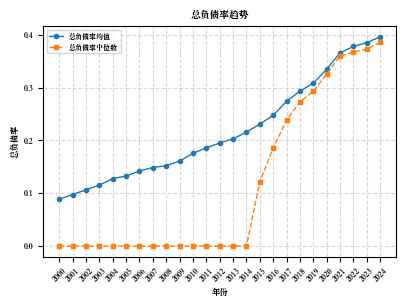

时序图B2已保存至: /Users/wanshiqing/Desktop/ROA_Cash_Trend.png


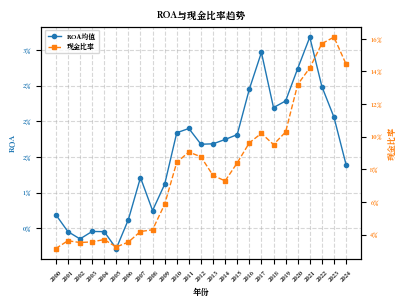


关键统计数据：
      时间  Lev_平均值  Lev_中位数  ROA_平均值  Cash_平均值
0   2000   0.0889   0.0000   0.0069    0.0316
1   2001   0.0977   0.0000   0.0045    0.0364
2   2002   0.1067   0.0000   0.0035    0.0353
3   2003   0.1157   0.0000   0.0045    0.0357
4   2004   0.1277   0.0000   0.0045    0.0371
5   2005   0.1329   0.0000   0.0021    0.0325
6   2006   0.1423   0.0000   0.0062    0.0356
7   2007   0.1489   0.0000   0.0121    0.0420
8   2008   0.1523   0.0000   0.0075    0.0431
9   2009   0.1611   0.0000   0.0112    0.0587
10  2010   0.1757   0.0000   0.0184    0.0844
11  2011   0.1860   0.0000   0.0190    0.0907
12  2012   0.1952   0.0000   0.0168    0.0878
13  2013   0.2032   0.0000   0.0168    0.0763
14  2014   0.2157   0.0000   0.0175    0.0730
15  2015   0.2309   0.1214   0.0181    0.0840
16  2016   0.2475   0.1859   0.0245    0.0963
17  2017   0.2741   0.2383   0.0297    0.1021
18  2018   0.2934   0.2728   0.0219    0.0953
19  2019   0.3085   0.2933   0.0229    0.1029
20  2020   0.3346   0.325

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import numpy as np
from datetime import datetime
import os

# macOS 中文显示解决方案
# 1. 检查并设置中文字体
try:
    # 尝试查找 macOS 系统自带的中文字体
    font_names = ['Songti SC', 'STHeiti', 'PingFang SC', 'Hiragino Sans GB']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 寻找可用的中文字体
    chinese_font = None
    for font in font_names:
        if font in available_fonts:
            chinese_font = font
            break
    
    # 如果找到可用字体，设置matplotlib使用它
    if chinese_font:
        plt.rcParams['font.sans-serif'] = [chinese_font]
        print(f"使用中文字体: {chinese_font}")
    else:
        # 如果找不到系统字体，尝试安装并使用SimHei字体
        print("未找到系统自带中文字体，尝试安装SimHei...")
        try:
            # 安装SimHei字体
            !pip install fonttools
            !wget https://github.com/stylishzhang/simhei-font/raw/master/simhei.ttf -O simhei.ttf
            font_path = os.path.join(os.getcwd(), 'simhei.ttf')
            fm.fontManager.addfont(font_path)
            plt.rcParams['font.sans-serif'] = ['SimHei']
            print("成功安装并使用SimHei字体")
        except:
            print("无法安装SimHei字体，使用英文标题")
            USE_CHINESE = False
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
except:
    print("字体设置失败，使用英文标题")
    USE_CHINESE = False

# 2. 设置标题和标签的函数，根据情况使用中文或英文
def set_title(title_chinese, title_english):
    if 'USE_CHINESE' in globals() and not USE_CHINESE:
        plt.title(title_english, fontsize=7)  # 减小标题字体
    else:
        plt.title(title_chinese, fontsize=7)  # 减小标题字体

def set_labels(xlabel_chinese, xlabel_english, ylabel_chinese, ylabel_english):
    if 'USE_CHINESE' in globals() and not USE_CHINESE:
        plt.xlabel(xlabel_english, fontsize=6)  # 减小坐标轴标签字体
        plt.ylabel(ylabel_english, fontsize=6)  # 减小坐标轴标签字体
    else:
        plt.xlabel(xlabel_chinese, fontsize=6)  # 减小坐标轴标签字体
        plt.ylabel(ylabel_chinese, fontsize=6)  # 减小坐标轴标签字体

# 读取第三步分组统计结果数据
input_path = '/Users/wanshiqing/Desktop/python_code/time_grouped_statistics.xlsx'
df = pd.read_excel(input_path)

# 确保时间列是整数类型
df['时间'] = df['时间'].astype(int)

# 按时间排序
df = df.sort_values('时间')  # 确保使用正确的中文列名

# 1. 绘制时序图B1：Lev的均值和中位数
plt.figure(figsize=(4, 3))
plt.plot(df['时间'], df['Lev_平均值'], label='Lev Mean' if 'USE_CHINESE' in globals() and not USE_CHINESE else '总负债率均值', 
         marker='o', markersize=3, linewidth=1, color='#1f77b4')  # 减小标记大小和线宽
plt.plot(df['时间'], df['Lev_中位数'], label='Lev Median' if 'USE_CHINESE' in globals() and not USE_CHINESE else '总负债率中位数', 
         marker='s', markersize=3, linestyle='--', linewidth=1, color='#ff7f0e')  # 减小标记大小和线宽

# 设置标题和标签
set_title(f'总负债率趋势',  # 简化标题文字
          f'Leverage Ratio Trend')  # 简化标题文字
set_labels('年份', 'Year', '总负债率', 'Leverage Ratio')

# 设置网格和刻度
plt.grid(True, linestyle='--', alpha=0.5)  # 减小网格透明度
plt.xticks(df['时间'], rotation=45, fontsize=6)  # 减小刻度字体
plt.yticks(fontsize=6)  # 减小刻度字体

# 添加图例
plt.legend(fontsize=5, loc='best')  # 减小图例字体，自动选择最佳位置

# 美化布局
plt.tight_layout(pad=0.5)  # 减小内边距

# 保存图像
output_path_b1 = '/Users/wanshiqing/Desktop/Leverage_Trend.png'
plt.savefig(output_path_b1, dpi=300, bbox_inches='tight')  # 裁剪多余空白
print(f"时序图B1已保存至: {output_path_b1}")

# 显示图像
plt.show()

# 2. 绘制时序图B2：ROA和Cash的均值（双纵坐标）
fig, ax1 = plt.subplots(figsize=(4, 3))

# 绘制ROA均值（左侧坐标轴）
color = '#1f77b4'
ax1.plot(df['时间'], df['ROA_平均值'], 
         label='ROA Mean' if 'USE_CHINESE' in globals() and not USE_CHINESE else 'ROA均值', 
         marker='o', markersize=3, linewidth=1, color=color)  # 减小标记大小和线宽
ax1.set_xlabel('Year' if 'USE_CHINESE' in globals() and not USE_CHINESE else '年份', fontsize=6)  # 减小字体
ax1.set_ylabel('ROA' if 'USE_CHINESE' in globals() and not USE_CHINESE else 'ROA',  # 简化标签
               color=color, fontsize=6)  # 减小字体
ax1.tick_params(axis='y', labelcolor=color, labelsize=5)  # 减小刻度字体
ax1.tick_params(axis='x', labelsize=5)  # 减小刻度字体
ax1.grid(True, linestyle='--', alpha=0.5)  # 减小网格透明度

# 创建第二个坐标轴（共享x轴）
ax2 = ax1.twinx()

# 绘制Cash均值（右侧坐标轴）
color = '#ff7f0e'
ax2.plot(df['时间'], df['Cash_平均值'], 
         label='Cash Ratio' if 'USE_CHINESE' in globals() and not USE_CHINESE else '现金比率',  # 简化标签
         marker='s', markersize=3, linestyle='--', linewidth=1, color=color)  # 减小标记大小和线宽
ax2.set_ylabel('Cash Ratio' if 'USE_CHINESE' in globals() and not USE_CHINESE else '现金比率',  # 简化标签
               color=color, fontsize=6)  # 减小字体
ax2.tick_params(axis='y', labelcolor=color, labelsize=5)  # 减小刻度字体

# 设置标题
plt.title(f'ROA and Cash Ratio Trend'  # 简化标题
          if 'USE_CHINESE' in globals() and not USE_CHINESE 
          else f'ROA与现金比率趋势',  # 简化标题
          fontsize=7)  # 减小标题字体

# 设置x轴刻度
ax1.set_xticks(df['时间'])
ax1.set_xticklabels(df['时间'], rotation=45, fontsize=5)  # 减小刻度字体

# 添加图例（合并两个坐标轴的图例）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=5, loc='best')  # 减小图例字体，自动选择最佳位置

# 格式化y轴标签为百分比
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))  # 简化百分比格式
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))  # 简化百分比格式

# 美化布局
fig.tight_layout(pad=0.5)  # 减小内边距

# 保存图像
output_path_b2 = '/Users/wanshiqing/Desktop/ROA_Cash_Trend.png'
plt.savefig(output_path_b2, dpi=300, bbox_inches='tight')  # 裁剪多余空白
print(f"时序图B2已保存至: {output_path_b2}")

# 显示图像
plt.show()

# 可选：输出统计数据用于参考
print("\n关键统计数据：")
print(df[['时间', 'Lev_平均值', 'Lev_中位数', 'ROA_平均值', 'Cash_平均值']].round(4))

使用中文字体: Songti SC
Lev字段计算完成
发现无法映射的行业代码: ['I' 'M' 'n' 'N' 'H' 'S' 'L' 'A' 'Q' 'R' 'B' 'P' 'O']
行业总负债率时序图已保存至: /Users/wanshiqing/Desktop/Industry_Lev_Trends.png


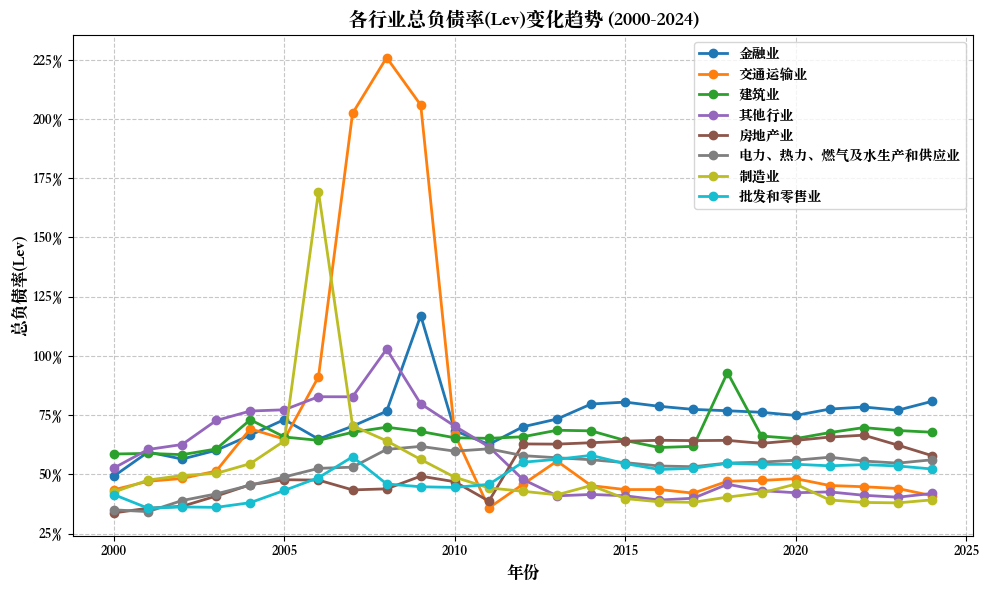


各行业平均总负债率:
行业
金融业                 73.06%
交通运输业               69.84%
建筑业                 66.57%
其他行业                57.21%
房地产业                53.43%
电力、热力、燃气及水生产和供应业    52.61%
制造业                 51.64%
批发和零售业              48.92%
Name: Lev, dtype: object
小尺寸行业总负债率时序图已保存至: /Users/wanshiqing/Desktop/Industry_Lev_Trends_small.png


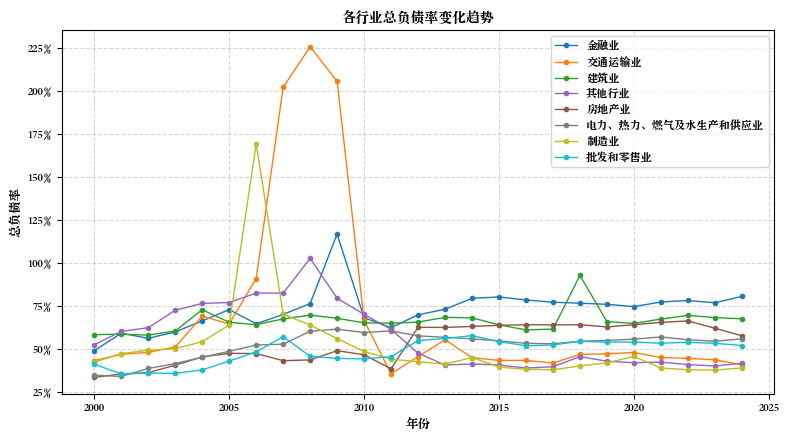

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import os

# 设置中文字体（适用于Mac系统）
try:
    # 尝试查找 macOS 系统自带的中文字体
    font_names = ['Songti SC', 'STHeiti', 'PingFang SC', 'Hiragino Sans GB', 'Arial Unicode MS']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 寻找可用的中文字体
    chinese_font = None
    for font in font_names:
        if font in available_fonts:
            chinese_font = font
            break
    
    # 如果找到可用字体，设置matplotlib使用它
    if chinese_font:
        plt.rcParams['font.sans-serif'] = [chinese_font]
        print(f"使用中文字体: {chinese_font}")
    else:
        print("未找到系统自带中文字体，使用英文标签")
        USE_CHINESE = False
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
except:
    print("字体设置失败，使用英文标签")
    USE_CHINESE = False

# 读取数据
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
df = pd.read_excel(input_path)

# 新增并计算Lev字段（总负债率 = 负债合计 / 资产总计）
# 确保字段存在并处理分母为零的情况
if '负债合计' in df.columns and '资产总计' in df.columns:
    # 安全除法，避免分母为零
    df['Lev'] = np.where(df['资产总计'] != 0, 
                       df['负债合计'] / df['资产总计'], 
                       np.nan)
    print("Lev字段计算完成")
else:
    # 如果字段不存在，尝试可能的变体
    possible_debt = [col for col in df.columns if '负债合计' in col or '负债' in col]
    possible_assets = [col for col in df.columns if '资产总计' in col or '资产' in col]
    
    if possible_debt and possible_assets:
        debt_col = possible_debt[0]
        assets_col = possible_assets[0]
        df['Lev'] = np.where(df[assets_col] != 0, 
                           df[debt_col] / df[assets_col], 
                           np.nan)
        print(f"使用替代字段计算Lev: {debt_col}/{assets_col}")
    else:
        raise ValueError("无法找到计算Lev所需的字段（负债合计和资产总计）")

# 1. 创建行业映射
industry_mapping = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 提取行业代码的首字母
if '行业代码' in df.columns:
    df['行业代码'] = df['行业代码'].astype(str)
    df['行业首字母'] = df['行业代码'].str[0]
else:
    # 如果行业代码字段不存在，尝试可能的变体
    possible_industry = [col for col in df.columns if '行业' in col or 'industry' in col.lower()]
    if possible_industry:
        industry_col = possible_industry[0]
        df['行业首字母'] = df[industry_col].astype(str).str[0]
        print(f"使用替代字段作为行业代码: {industry_col}")
    else:
        raise ValueError("无法找到行业代码字段")

# 创建行业字段
df['行业'] = df['行业首字母'].map(industry_mapping)

# 处理无法映射的行业
unknown_industry = df[df['行业'].isna()]['行业首字母'].unique()
if len(unknown_industry) > 0:
    print(f"发现无法映射的行业代码: {unknown_industry}")
    df['行业'] = df['行业'].fillna('其他行业')

# 2. 按'时间'和'行业'分组
# 3. 计算各行业各时间的总负债率(Lev)均值
# 确保时间字段存在
if '时间' not in df.columns:
    # 尝试可能的变体
    possible_time = [col for col in df.columns if '时间' in col or 'year' in col.lower() or 'date' in col.lower()]
    if possible_time:
        time_col = possible_time[0]
        df.rename(columns={time_col: '时间'}, inplace=True)
        print(f"使用替代字段作为时间: {time_col}")
    else:
        raise ValueError("无法找到时间字段")

# 筛选2000年及以后的数据
df = df[df['时间'] >= 2000]

# 按时间和行业分组计算Lev均值
industry_lev = df.groupby(['时间', '行业'])['Lev'].mean().reset_index()

# 按时间排序
industry_lev = industry_lev.sort_values(['时间', '行业'])

# 4. 绘制行业总负债率时序图
plt.figure(figsize=(10, 6))

# 获取行业列表并排序
industries = industry_lev['行业'].unique()
sorted_industries = sorted(industries, key=lambda x: industry_lev[industry_lev['行业'] == x]['Lev'].mean(), reverse=True)

# 设置颜色映射
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_industries)))

# 绘制各行业折线
for i, industry in enumerate(sorted_industries):
    industry_data = industry_lev[industry_lev['行业'] == industry]
    plt.plot(industry_data['时间'], industry_data['Lev'], 
             label=industry, marker='o', linewidth=2, color=colors[i])

# 设置标题和标签
if 'USE_CHINESE' in globals() and not USE_CHINESE:
    plt.title('Industry Leverage Ratio Trends (2000-{})'.format(industry_lev['时间'].max()), fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Leverage Ratio (Lev)', fontsize=12)
else:
    plt.title('各行业总负债率(Lev)变化趋势 (2000-{})'.format(industry_lev['时间'].max()), fontsize=14)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('总负债率(Lev)', fontsize=12)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.7)

# 添加图例
plt.legend(fontsize=10, loc='best')

# 设置y轴为百分比格式
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# 调整布局
plt.tight_layout()

# 保存图像
output_path = '/Users/wanshiqing/Desktop/Industry_Lev_Trends.png'
plt.savefig(output_path, dpi=300)
print(f"行业总负债率时序图已保存至: {output_path}")

# 显示图像
plt.show()

# 可选：输出各行业平均负债率
print("\n各行业平均总负债率:")
industry_avg = industry_lev.groupby('行业')['Lev'].mean().sort_values(ascending=False)
print(industry_avg.apply(lambda x: f"{x:.2%}"))

# 可选：绘制小尺寸图表（用于论文）
plt.figure(figsize=(8, 4.5))

# 绘制各行业折线（更细线条）
for i, industry in enumerate(sorted_industries):
    industry_data = industry_lev[industry_lev['行业'] == industry]
    plt.plot(industry_data['时间'], industry_data['Lev'], 
             label=industry, marker='o', markersize=3, linewidth=1, color=colors[i])

# 设置标题和标签（更小字体）
if 'USE_CHINESE' in globals() and not USE_CHINESE:
    plt.title('Industry Leverage Ratio Trends', fontsize=10)
    plt.xlabel('Year', fontsize=9)
    plt.ylabel('Leverage Ratio', fontsize=9)
else:
    plt.title('各行业总负债率变化趋势', fontsize=10)
    plt.xlabel('年份', fontsize=9)
    plt.ylabel('总负债率', fontsize=9)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.5)

# 添加图例（更小字体）
plt.legend(fontsize=8, loc='best')

# 设置y轴为百分比格式
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# 设置刻度字体
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 调整布局
plt.tight_layout()

# 保存小尺寸图像
small_output_path = '/Users/wanshiqing/Desktop/Industry_Lev_Trends_small.png'
plt.savefig(small_output_path, dpi=300, bbox_inches='tight')
print(f"小尺寸行业总负债率时序图已保存至: {small_output_path}")

# 显示图像
plt.show()

使用中文字体: Songti SC
正在读取文件: /Users/wanshiqing/Desktop/python_code/merged_data.xlsx
数据读取成功! 共 145874 行记录

计算总负债率(Lev)...
Lev字段计算完成

创建行业字段...
发现无法映射的行业代码: ['I' 'M' 'n' 'N' 'H' 'S' 'L' 'A' 'Q' 'R' 'B' 'P' 'O']

行业分布统计:
行业
其他行业                92759
制造业                 40346
批发和零售业               2770
交通运输业                2447
房地产业                 2065
金融业                  2027
电力、热力、燃气及水生产和供应业     2004
建筑业                  1456
Name: count, dtype: int64

计算权重...

计算年加权平均负债率...

绘制时序图...
行业加权平均负债率时序图已保存至: /Users/wanshiqing/Desktop/Industry_Weighted_Lev_Trends.png


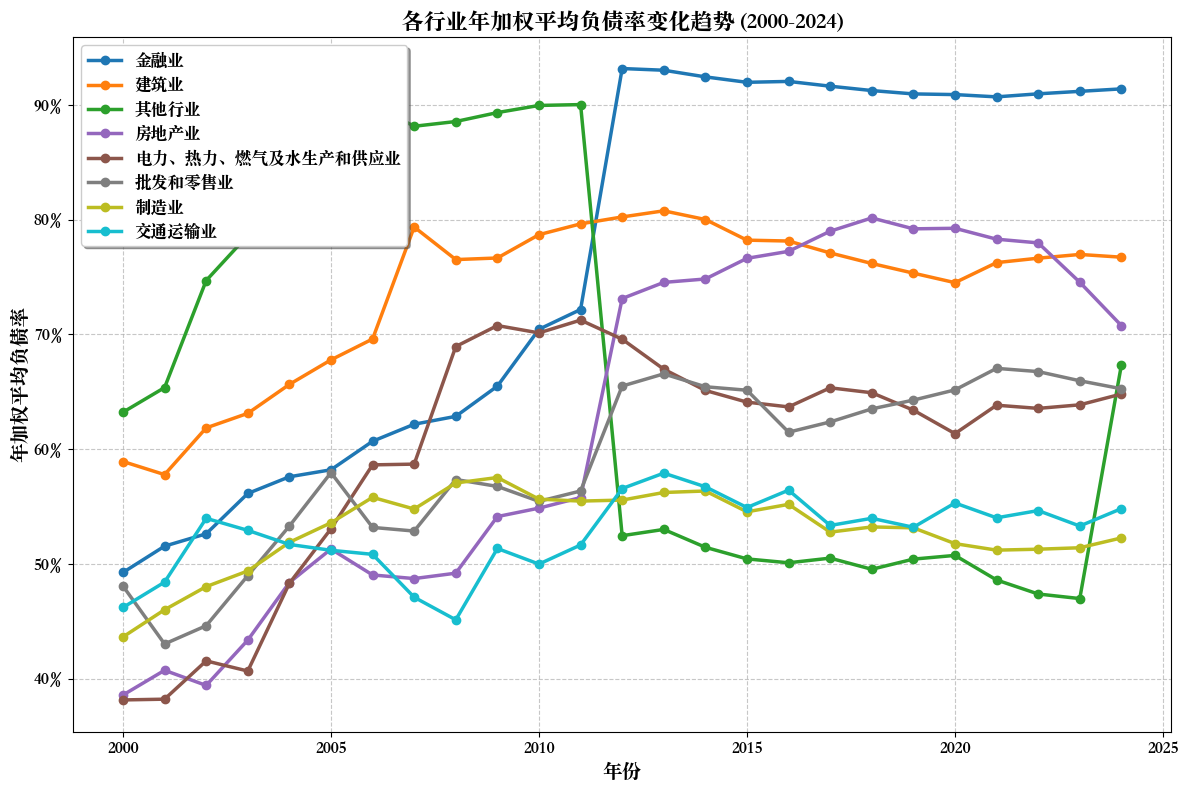


各行业平均加权负债率:
行业
金融业                 76.42%
建筑业                 73.70%
其他行业                65.89%
房地产业                62.75%
电力、热力、燃气及水生产和供应业    59.95%
批发和零售业              58.89%
制造业                 52.94%
交通运输业               52.62%
Name: 年加权平均负债率, dtype: object
加权平均负债率数据已保存至: /Users/wanshiqing/Desktop/weighted_industry_lev.csv
处理后的完整数据已保存至: /Users/wanshiqing/Desktop/processed_data.xlsx

第六步处理完成!


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import os

# 设置中文字体（适用于Mac系统）
try:
    # 尝试查找 macOS 系统自带的中文字体
    font_names = ['Songti SC', 'STHeiti', 'PingFang SC', 'Hiragino Sans GB', 'Arial Unicode MS']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 寻找可用的中文字体
    chinese_font = None
    for font in font_names:
        if font in available_fonts:
            chinese_font = font
            break
    
    # 如果找到可用字体，设置matplotlib使用它
    if chinese_font:
        plt.rcParams['font.sans-serif'] = [chinese_font]
        print(f"使用中文字体: {chinese_font}")
    else:
        print("未找到系统自带中文字体，使用英文标签")
        USE_CHINESE = False
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
except:
    print("字体设置失败，使用英文标签")
    USE_CHINESE = False

# 1. 读取文件
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
print(f"正在读取文件: {input_path}")
df = pd.read_excel(input_path)
print(f"数据读取成功! 共 {len(df)} 行记录")

# 2. 计算Lev = 总负债率 = 负债合计/资产总计
print("\n计算总负债率(Lev)...")
if '负债合计' in df.columns and '资产总计' in df.columns:
    # 安全除法，避免分母为零
    df['Lev'] = np.where(df['资产总计'] != 0, 
                       df['负债合计'] / df['资产总计'], 
                       np.nan)
    print("Lev字段计算完成")
else:
    # 如果字段不存在，尝试可能的变体
    possible_debt = [col for col in df.columns if '负债合计' in col or '负债' in col]
    possible_assets = [col for col in df.columns if '资产总计' in col or '资产' in col]
    
    if possible_debt and possible_assets:
        debt_col = possible_debt[0]
        assets_col = possible_assets[0]
        df['Lev'] = np.where(df[assets_col] != 0, 
                           df[debt_col] / df[assets_col], 
                           np.nan)
        print(f"使用替代字段计算Lev: {debt_col}/{assets_col}")
    else:
        raise ValueError("无法找到计算Lev所需的字段（负债合计和资产总计）")

# 3. 创建行业映射
print("\n创建行业字段...")
industry_mapping = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 确保行业代码字段存在
if '行业代码' not in df.columns:
    # 尝试查找可能的替代字段
    possible_cols = [col for col in df.columns if '行业' in col or 'industry' in col.lower()]
    if possible_cols:
        print(f"使用替代字段作为行业代码: {possible_cols[0]}")
        industry_col = possible_cols[0]
    else:
        raise ValueError("无法找到行业代码字段")
else:
    industry_col = '行业代码'

# 将行业代码转换为字符串类型
df[industry_col] = df[industry_col].astype(str)

# 提取行业代码的首字母
df['行业首字母'] = df[industry_col].str[0]

# 创建行业字段
df['行业'] = df['行业首字母'].map(industry_mapping)

# 处理无法映射的行业代码
unknown_industries = df[df['行业'].isna()]['行业首字母'].unique()
if len(unknown_industries) > 0:
    print(f"发现无法映射的行业代码: {unknown_industries}")
    # 将这些行业归类为"其他行业"
    df['行业'] = df['行业'].fillna('其他行业')

# 显示行业分布情况
industry_counts = df['行业'].value_counts()
print("\n行业分布统计:")
print(industry_counts)

# 4. 按行业内每家公司的总资产计算权重
print("\n计算权重...")
# 先按年份和行业分组，计算每个行业每年的总资产
industry_year_assets = df.groupby(['时间', '行业'])['资产总计'].sum().reset_index()
industry_year_assets.rename(columns={'资产总计': '行业年总资产'}, inplace=True)

# 合并回原始数据框
df = pd.merge(df, industry_year_assets, on=['时间', '行业'], how='left')

# 计算权重：公司资产 / 行业年总资产
df['权重'] = df['资产总计'] / df['行业年总资产']

# 5. 按'行业'和'时间'分组，计算年加权平均负债率
print("\n计算年加权平均负债率...")
# 加权平均负债率 = Σ(权重 * Lev)
df['加权负债率'] = df['权重'] * df['Lev']
weighted_lev = df.groupby(['时间', '行业'])['加权负债率'].sum().reset_index()
weighted_lev.rename(columns={'加权负债率': '年加权平均负债率'}, inplace=True)

# 筛选2000年及以后的数据
weighted_lev = weighted_lev[weighted_lev['时间'] >= 2000]

# 按时间排序
weighted_lev = weighted_lev.sort_values(['时间', '行业'])

# 6. 绘制加权平均负债率时序图
print("\n绘制时序图...")
plt.figure(figsize=(12, 8))

# 获取行业列表并排序
industries = weighted_lev['行业'].unique()
sorted_industries = sorted(industries, key=lambda x: weighted_lev[weighted_lev['行业'] == x]['年加权平均负债率'].mean(), 
                           reverse=True)

# 设置颜色映射
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_industries)))

# 绘制各行业折线
for i, industry in enumerate(sorted_industries):
    industry_data = weighted_lev[weighted_lev['行业'] == industry]
    plt.plot(industry_data['时间'], industry_data['年加权平均负债率'], 
             label=industry, marker='o', linewidth=2.5, color=colors[i])

# 设置标题和标签
if 'USE_CHINESE' in globals() and not USE_CHINESE:
    plt.title('Industry Weighted Average Leverage Ratio (2000-{})'.format(weighted_lev['时间'].max()), fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Weighted Average Leverage Ratio', fontsize=14)
else:
    plt.title('各行业年加权平均负债率变化趋势 (2000-{})'.format(weighted_lev['时间'].max()), fontsize=16)
    plt.xlabel('年份', fontsize=14)
    plt.ylabel('年加权平均负债率', fontsize=14)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.7)

# 添加图例
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)

# 设置y轴为百分比格式
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# 设置x轴刻度
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 调整布局
plt.tight_layout()

# 保存图像
output_path = '/Users/wanshiqing/Desktop/Industry_Weighted_Lev_Trends.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"行业加权平均负债率时序图已保存至: {output_path}")

# 显示图像
plt.show()

# 可选：输出各行业平均加权负债率
print("\n各行业平均加权负债率:")
industry_avg = weighted_lev.groupby('行业')['年加权平均负债率'].mean().sort_values(ascending=False)
print(industry_avg.apply(lambda x: f"{x:.2%}"))

# 可选：保存加权平均结果
output_csv_path = '/Users/wanshiqing/Desktop/weighted_industry_lev.csv'
weighted_lev.to_csv(output_csv_path, index=False)
print(f"加权平均负债率数据已保存至: {output_csv_path}")

# 保存处理后的数据
output_excel_path = '/Users/wanshiqing/Desktop/processed_data.xlsx'
df.to_excel(output_excel_path, index=False)
print(f"处理后的完整数据已保存至: {output_excel_path}")

# 完成
print("\n第六步处理完成!")

In [39]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. 读取文件
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
print(f"正在读取文件: {input_path}")
df = pd.read_excel(input_path)
print(f"数据读取成功! 共 {len(df)} 行记录")
print(f"原始字段: {df.columns.tolist()}")

# 2. 计算并新增字段
print("\n计算并新增财务指标字段...")
def safe_divide(numerator, denominator):
    """安全除法函数，处理分母为零的情况"""
    return np.where(denominator != 0, numerator / denominator, np.nan)

# 确保所需字段存在
required_fields = ['短期借款', '长期借款', '负债合计', '资产总计', '期末现金及现金等价物余额', 
                  '净利润', '所有者权益合计']
for field in required_fields:
    if field not in df.columns:
        print(f"警告: 字段 '{field}' 不存在，尝试查找替代字段...")
        # 尝试查找可能的替代字段
        possible_cols = [col for col in df.columns if field in col or field.lower() in col.lower()]
        if possible_cols:
            df.rename(columns={possible_cols[0]: field}, inplace=True)
            print(f"  使用替代字段: {possible_cols[0]} 作为 {field}")
        else:
            raise ValueError(f"无法找到必需的字段: {field}")

# 计算新增字段
df['SLoan'] = safe_divide(df['短期借款'], df['资产总计'])
df['LLoan'] = safe_divide(df['长期借款'], df['资产总计'])
df['Lev'] = safe_divide(df['负债合计'], df['资产总计'])
df['Cash'] = safe_divide(df['期末现金及现金等价物余额'], df['资产总计'])
df['ROA'] = safe_divide(df['净利润'], df['资产总计'])
df['ROE'] = safe_divide(df['净利润'], df['所有者权益合计'])

# 检查计算结果
print("新增字段计算完成:")
print(f"  SLoan: {df['SLoan'].notna().sum()} 个有效值")
print(f"  LLoan: {df['LLoan'].notna().sum()} 个有效值")
print(f"  Lev: {df['Lev'].notna().sum()} 个有效值")
print(f"  Cash: {df['Cash'].notna().sum()} 个有效值")
print(f"  ROA: {df['ROA'].notna().sum()} 个有效值")
print(f"  ROE: {df['ROE'].notna().sum()} 个有效值")

# 3. 创建行业字段
print("\n创建行业字段...")
industry_mapping = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 确保行业代码字段存在
if '行业代码' not in df.columns:
    # 尝试查找可能的替代字段
    possible_cols = [col for col in df.columns if '行业' in col or 'industry' in col.lower()]
    if possible_cols:
        print(f"使用替代字段作为行业代码: {possible_cols[0]}")
        industry_col = possible_cols[0]
    else:
        raise ValueError("无法找到行业代码字段")
else:
    industry_col = '行业代码'

# 将行业代码转换为字符串类型
df[industry_col] = df[industry_col].astype(str)

# 提取行业代码的首字母
df['行业首字母'] = df[industry_col].str[0]

# 创建行业字段
df['行业'] = df['行业首字母'].map(industry_mapping)

# 处理无法映射的行业代码
unknown_industries = df[df['行业'].isna()]['行业首字母'].unique()
if len(unknown_industries) > 0:
    print(f"发现无法映射的行业代码: {unknown_industries}")
    # 将这些行业归类为"其他行业"
    df['行业'] = df['行业'].fillna('其他行业')

# 显示行业分布情况
industry_counts = df['行业'].value_counts()
print("\n行业分布统计:")
print(industry_counts)

# 4. 按'行业'和'时间'分组，计算平均值
print("\n按行业和时间分组计算平均值...")
# 筛选2000年及以后的数据
df = df[df['时间'] >= 2000]

# 分组计算平均值
grouped = df.groupby(['行业', '时间']).agg({
    'SLoan': 'mean',
    'LLoan': 'mean',
    'Lev': 'mean',
    'Cash': 'mean',
    'ROA': 'mean',
    'ROE': 'mean'
}).reset_index()

# 重命名列
grouped.rename(columns={
    'SLoan': '短期借款比率',
    'LLoan': '长期借款比率',
    'Lev': '总负债率',
    'Cash': '现金比率',
    'ROA': '资产收益率',
    'ROE': '净资产收益率'
}, inplace=True)

# 按时间和行业排序
grouped = grouped.sort_values(['时间', '行业'])

# 5. 列表呈现
print("\n按行业和时间分组的财务指标平均值:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f"{x:.4f}" if isinstance(x, float) else x)

# 显示表格
print(grouped)

# 保存结果到Excel（保留原始数值）
output_path = '/Users/wanshiqing/Desktop/industry_financial_metrics.xlsx'
grouped.to_excel(output_path, index=False)
print(f"\n结果已保存至: {output_path}")

# 创建格式化版本用于展示
formatted_grouped = grouped.copy()
percent_cols = ['短期借款比率', '长期借款比率', '总负债率', '现金比率', '资产收益率', '净资产收益率']
for col in percent_cols:
    formatted_grouped[col] = formatted_grouped[col].apply(lambda x: f"{x:.2%}" if pd.notnull(x) else "")

# 保存格式化版本
formatted_output_path = '/Users/wanshiqing/Desktop/industry_financial_metrics_formatted.xlsx'
formatted_grouped.to_excel(formatted_output_path, index=False)
print(f"格式化结果已保存至: {formatted_output_path}")

# 按行业汇总（使用原始数值）
industry_summary = grouped.groupby('行业').agg({
    '短期借款比率': 'mean',
    '长期借款比率': 'mean',
    '总负债率': 'mean',
    '现金比率': 'mean',
    '资产收益率': 'mean',
    '净资产收益率': 'mean'
}).reset_index()

# 创建格式化版本用于展示
formatted_summary = industry_summary.copy()
for col in percent_cols:
    formatted_summary[col] = formatted_summary[col].apply(lambda x: f"{x:.2%}" if pd.notnull(x) else "")

print("\n按行业汇总的财务指标平均值:")
print(formatted_summary)

# 保存行业汇总结果
summary_output_path = '/Users/wanshiqing/Desktop/industry_summary.xlsx'
industry_summary.to_excel(summary_output_path, index=False)
print(f"行业汇总结果已保存至: {summary_output_path}")

# 保存格式化行业汇总结果
formatted_summary_output_path = '/Users/wanshiqing/Desktop/industry_summary_formatted.xlsx'
formatted_summary.to_excel(formatted_summary_output_path, index=False)
print(f"格式化行业汇总结果已保存至: {formatted_summary_output_path}")

# 保存处理后的完整数据
full_output_path = '/Users/wanshiqing/Desktop/processed_financial_data.xlsx'
df.to_excel(full_output_path, index=False)
print(f"处理后的完整数据已保存至: {full_output_path}")

print("\n第七步处理完成!")

正在读取文件: /Users/wanshiqing/Desktop/python_code/merged_data.xlsx
数据读取成功! 共 145874 行记录
原始字段: ['证券代码', '时间', '负债合计', '资产总计', '流动负债合计', '长期负债合计', '所有者权益合计', '短期借款', '长期借款', '股权集中度1', '股权集中度9', '首次上市日期', '行业代码', '期末现金及现金等价物余额', '净利润']

计算并新增财务指标字段...
新增字段计算完成:
  SLoan: 62635 个有效值
  LLoan: 52544 个有效值
  Lev: 71787 个有效值
  Cash: 71637 个有效值
  ROA: 71787 个有效值
  ROE: 71785 个有效值

创建行业字段...
发现无法映射的行业代码: ['I' 'M' 'n' 'N' 'H' 'S' 'L' 'A' 'Q' 'R' 'B' 'P' 'O']

行业分布统计:
行业
其他行业                92759
制造业                 40346
批发和零售业               2770
交通运输业                2447
房地产业                 2065
金融业                  2027
电力、热力、燃气及水生产和供应业     2004
建筑业                  1456
Name: count, dtype: int64

按行业和时间分组计算平均值...

按行业和时间分组的财务指标平均值:
                   行业    时间  短期借款比率  长期借款比率   总负债率   现金比率    资产收益率  净资产收益率
0               交通运输业  2000  0.1634  0.0255 0.4352 0.2127   0.0510  0.0894
25               其他行业  2000  0.2289  0.0481 0.5270 0.1506   0.0124 -0.0290
50                制造业  2000  0.1564  0.0518 0.

In [40]:
import pandas as pd
import numpy as np
from openpyxl.styles import Border, Side, PatternFill, Font
from openpyxl.utils import get_column_letter

# 1. 读取文件
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
print(f"正在读取文件: {input_path}")
df = pd.read_excel(input_path)
print(f"数据读取成功! 共 {len(df)} 行记录")

# 2. 计算并新增字段
print("\n计算并新增财务指标字段...")
def safe_divide(numerator, denominator):
    """安全除法函数，处理分母为零的情况"""
    return np.where(denominator != 0, numerator / denominator, np.nan)

# 确保所需字段存在
required_fields = ['短期借款', '长期借款', '负债合计', '资产总计', '期末现金及现金等价物余额', 
                  '净利润', '所有者权益合计']
for field in required_fields:
    if field not in df.columns:
        print(f"警告: 字段 '{field}' 不存在，尝试查找替代字段...")
        possible_cols = [col for col in df.columns if field in col or field.lower() in col.lower()]
        if possible_cols:
            df.rename(columns={possible_cols[0]: field}, inplace=True)
            print(f"  使用替代字段: {possible_cols[0]} 作为 {field}")
        else:
            raise ValueError(f"无法找到必需的字段: {field}")

# 计算新增字段
df['SLoan'] = safe_divide(df['短期借款'], df['资产总计'])
df['LLoan'] = safe_divide(df['长期借款'], df['资产总计'])
df['Lev'] = safe_divide(df['负债合计'], df['资产总计'])
df['Cash'] = safe_divide(df['期末现金及现金等价物余额'], df['资产总计'])
df['ROA'] = safe_divide(df['净利润'], df['资产总计'])
df['ROE'] = safe_divide(df['净利润'], df['所有者权益合计'])

# 3. 创建行业字段
print("\n创建行业字段...")
industry_mapping = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 确保行业代码字段存在
if '行业代码' not in df.columns:
    possible_cols = [col for col in df.columns if '行业' in col or 'industry' in col.lower()]
    if possible_cols:
        print(f"使用替代字段作为行业代码: {possible_cols[0]}")
        industry_col = possible_cols[0]
    else:
        raise ValueError("无法找到行业代码字段")
else:
    industry_col = '行业代码'

# 将行业代码转换为字符串类型
df[industry_col] = df[industry_col].astype(str)
df['行业首字母'] = df[industry_col].str[0]
df['行业'] = df['行业首字母'].map(industry_mapping)

# 处理无法映射的行业代码
unknown_industries = df[df['行业'].isna()]['行业首字母'].unique()
if len(unknown_industries) > 0:
    print(f"发现无法映射的行业代码: {unknown_industries}")
    df['行业'] = df['行业'].fillna('其他行业')

# 4. 按'行业'和'时间'分组，计算平均值
print("\n按行业和时间分组计算平均值...")
df = df[df['时间'] >= 2000]
grouped = df.groupby(['行业', '时间']).agg({
    'SLoan': 'mean',
    'LLoan': 'mean',
    'Lev': 'mean',
    'Cash': 'mean',
    'ROA': 'mean',
    'ROE': 'mean'
}).reset_index()

# 重命名列
grouped.rename(columns={
    'SLoan': '短期借款比率',
    'LLoan': '长期借款比率',
    'Lev': '总负债率',
    'Cash': '现金比率',
    'ROA': '资产收益率',
    'ROE': '净资产收益率'
}, inplace=True)

# 按时间和行业排序
grouped = grouped.sort_values(['时间', '行业'])

# 5. 创建美观的实线表格
print("\n创建美观的实线表格...")

# 定义样式函数
def format_table(styler):
    # 设置百分比格式
    styler.format({
        '短期借款比率': '{:.2%}',
        '长期借款比率': '{:.2%}',
        '总负债率': '{:.2%}',
        '现金比率': '{:.2%}',
        '资产收益率': '{:.2%}',
        '净资产收益率': '{:.2%}'
    })
    
    # 设置表头样式
    styler.set_table_styles([
        {'selector': 'th', 'props': [
            ('border', '1px solid black'),
            ('background-color', '#4F81BD'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]},
        {'selector': 'td', 'props': [
            ('border', '1px solid black'),
            ('text-align', 'center')
        ]},
        {'selector': 'tr:nth-child(even)', 'props': [
            ('background-color', '#DCE6F1')
        ]},
        {'selector': 'tr:nth-child(odd)', 'props': [
            ('background-color', 'white')
        ]}
    ])
    
    # 设置列宽
    styler.set_properties(**{
        'width': '100px',
        'max-width': '100px'
    })
    
    return styler

# 应用样式
styled_table = grouped.style.pipe(format_table)

# 保存为HTML
html_output_path = '/Users/wanshiqing/Desktop/industry_financial_metrics.html'
with open(html_output_path, 'w') as f:
    f.write(styled_table.to_html())
print(f"HTML表格已保存至: {html_output_path}")

# 保存为带格式的Excel
def apply_excel_formatting(writer, df, sheet_name='Sheet1'):
    """应用Excel格式设置"""
    workbook = writer.book
    worksheet = writer.sheets[sheet_name]
    
    # 定义边框样式
    thin_border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )
    
    # 定义填充颜色
    header_fill = PatternFill(start_color='4F81BD', end_color='4F81BD', fill_type='solid')
    even_row_fill = PatternFill(start_color='DCE6F1', end_color='DCE6F1', fill_type='solid')
    odd_row_fill = PatternFill(start_color='FFFFFF', end_color='FFFFFF', fill_type='solid')
    
    # 定义字体
    header_font = Font(color='FFFFFF', bold=True)
    data_font = Font()
    
    # 设置列宽
    for i, col in enumerate(df.columns):
        col_letter = get_column_letter(i + 1)
        worksheet.column_dimensions[col_letter].width = 15
    
    # 应用格式到所有单元格
    for row in range(0, len(df) + 1):
        for col in range(0, len(df.columns)):
            cell = worksheet.cell(row=row + 1, column=col + 1)
            cell.border = thin_border
            
            # 表头样式
            if row == 0:
                cell.fill = header_fill
                cell.font = header_font
            # 数据行样式
            else:
                if row % 2 == 0:
                    cell.fill = even_row_fill
                else:
                    cell.fill = odd_row_fill
                cell.font = data_font
    
    # 冻结首行
    worksheet.freeze_panes = 'A2'

# 保存为Excel
excel_output_path = '/Users/wanshiqing/Desktop/industry_financial_metrics.xlsx'
with pd.ExcelWriter(excel_output_path, engine='openpyxl') as writer:
    grouped.to_excel(writer, index=False, sheet_name='行业财务指标')
    apply_excel_formatting(writer, grouped, sheet_name='行业财务指标')
print(f"带格式的Excel表格已保存至: {excel_output_path}")

# 创建行业汇总表
industry_summary = grouped.groupby('行业').agg({
    '短期借款比率': 'mean',
    '长期借款比率': 'mean',
    '总负债率': 'mean',
    '现金比率': 'mean',
    '资产收益率': 'mean',
    '净资产收益率': 'mean'
}).reset_index()

# 应用样式到汇总表
styled_summary = industry_summary.style.pipe(format_table)

# 保存汇总表
summary_html_path = '/Users/wanshiqing/Desktop/industry_summary.html'
with open(summary_html_path, 'w') as f:
    f.write(styled_summary.to_html())
print(f"行业汇总HTML表格已保存至: {summary_html_path}")

# 保存汇总表到Excel
summary_excel_path = '/Users/wanshiqing/Desktop/industry_summary.xlsx'
with pd.ExcelWriter(summary_excel_path, engine='openpyxl') as writer:
    industry_summary.to_excel(writer, index=False, sheet_name='行业汇总')
    apply_excel_formatting(writer, industry_summary, sheet_name='行业汇总')
print(f"行业汇总Excel表格已保存至: {summary_excel_path}")

# 保存处理后的完整数据
full_output_path = '/Users/wanshiqing/Desktop/processed_financial_data.xlsx'
df.to_excel(full_output_path, index=False)
print(f"处理后的完整数据已保存至: {full_output_path}")

print("\n第七步处理完成!")

正在读取文件: /Users/wanshiqing/Desktop/python_code/merged_data.xlsx
数据读取成功! 共 145874 行记录

计算并新增财务指标字段...

创建行业字段...
发现无法映射的行业代码: ['I' 'M' 'n' 'N' 'H' 'S' 'L' 'A' 'Q' 'R' 'B' 'P' 'O']

按行业和时间分组计算平均值...

创建美观的实线表格...
HTML表格已保存至: /Users/wanshiqing/Desktop/industry_financial_metrics.html
带格式的Excel表格已保存至: /Users/wanshiqing/Desktop/industry_financial_metrics.xlsx
行业汇总HTML表格已保存至: /Users/wanshiqing/Desktop/industry_summary.html
行业汇总Excel表格已保存至: /Users/wanshiqing/Desktop/industry_summary.xlsx
处理后的完整数据已保存至: /Users/wanshiqing/Desktop/processed_financial_data.xlsx

第七步处理完成!


In [41]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# 1. 读取文件
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
print(f"正在读取文件: {input_path}")
df = pd.read_excel(input_path)
print(f"数据读取成功! 共 {len(df)} 行记录")

# 2. 计算并新增字段
print("\n计算并新增财务指标字段...")
def safe_divide(numerator, denominator):
    """安全除法函数，处理分母为零的情况"""
    return np.where(denominator != 0, numerator / denominator, np.nan)

# 确保所需字段存在
required_fields = ['短期借款', '长期借款', '负债合计', '资产总计', '期末现金及现金等价物余额', 
                  '净利润', '所有者权益合计']
for field in required_fields:
    if field not in df.columns:
        print(f"警告: 字段 '{field}' 不存在，尝试查找替代字段...")
        possible_cols = [col for col in df.columns if field in col or field.lower() in col.lower()]
        if possible_cols:
            df.rename(columns={possible_cols[0]: field}, inplace=True)
            print(f"  使用替代字段: {possible_cols[0]} 作为 {field}")
        else:
            raise ValueError(f"无法找到必需的字段: {field}")

# 计算新增字段
df['SLoan'] = safe_divide(df['短期借款'], df['资产总计'])
df['LLoan'] = safe_divide(df['长期借款'], df['资产总计'])
df['Lev'] = safe_divide(df['负债合计'], df['资产总计'])
df['Cash'] = safe_divide(df['期末现金及现金等价物余额'], df['资产总计'])
df['ROA'] = safe_divide(df['净利润'], df['资产总计'])
df['ROE'] = safe_divide(df['净利润'], df['所有者权益合计'])

# 3. 创建行业字段
print("\n创建行业字段...")
industry_mapping = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 确保行业代码字段存在
if '行业代码' not in df.columns:
    possible_cols = [col for col in df.columns if '行业' in col or 'industry' in col.lower()]
    if possible_cols:
        print(f"使用替代字段作为行业代码: {possible_cols[0]}")
        industry_col = possible_cols[0]
    else:
        raise ValueError("无法找到行业代码字段")
else:
    industry_col = '行业代码'

# 将行业代码转换为字符串类型
df[industry_col] = df[industry_col].astype(str)
df['行业首字母'] = df[industry_col].str[0]
df['行业'] = df['行业首字母'].map(industry_mapping)

# 处理无法映射的行业代码
unknown_industries = df[df['行业'].isna()]['行业首字母'].unique()
if len(unknown_industries) > 0:
    print(f"发现无法映射的行业代码: {unknown_industries}")
    df['行业'] = df['行业'].fillna('其他行业')

# 4. 按'行业'和'时间'分组，计算平均值
print("\n按行业和时间分组计算平均值...")
df = df[df['时间'] >= 2000]
grouped = df.groupby(['行业', '时间']).agg({
    'SLoan': 'mean',
    'LLoan': 'mean',
    'Lev': 'mean',
    'Cash': 'mean',
    'ROA': 'mean',
    'ROE': 'mean'
}).reset_index()

# 重命名列
grouped.rename(columns={
    'SLoan': '短期借款比率',
    'LLoan': '长期借款比率',
    'Lev': '总负债率',
    'Cash': '现金比率',
    'ROA': '资产收益率',
    'ROE': '净资产收益率'
}, inplace=True)

# 按时间和行业排序
grouped = grouped.sort_values(['时间', '行业'])

# 5. 在控制台输出美观的实线表格
print("\n按行业和时间分组的财务指标平均值:")

# 格式化百分比列
def format_percent(value):
    """将数值格式化为百分比字符串"""
    if pd.isnull(value):
        return ""
    return f"{value:.2%}"

# 应用格式化
formatted_grouped = grouped.copy()
for col in ['短期借款比率', '长期借款比率', '总负债率', '现金比率', '资产收益率', '净资产收益率']:
    formatted_grouped[col] = formatted_grouped[col].apply(format_percent)

# 使用tabulate创建美观的表格
table = tabulate(
    formatted_grouped,
    headers=[
        '行业', '年份', 
        '短期借款比率', '长期借款比率', 
        '总负债率', '现金比率',
        '资产收益率', '净资产收益率'
    ],
    tablefmt='grid',
    stralign='center',
    numalign='center',
    showindex=False
)

# 打印表格
print(table)

# 6. 按行业汇总并输出
print("\n\n按行业汇总的财务指标平均值:")

# 计算行业平均值
industry_summary = grouped.groupby('行业').agg({
    '短期借款比率': 'mean',
    '长期借款比率': 'mean',
    '总负债率': 'mean',
    '现金比率': 'mean',
    '资产收益率': 'mean',
    '净资产收益率': 'mean'
}).reset_index()

# 应用格式化
formatted_summary = industry_summary.copy()
for col in ['短期借款比率', '长期借款比率', '总负债率', '现金比率', '资产收益率', '净资产收益率']:
    formatted_summary[col] = formatted_summary[col].apply(format_percent)

# 创建汇总表格
summary_table = tabulate(
    formatted_summary,
    headers=[
        '行业', 
        '短期借款比率', '长期借款比率', 
        '总负债率', '现金比率',
        '资产收益率', '净资产收益率'
    ],
    tablefmt='grid',
    stralign='center',
    numalign='center',
    showindex=False
)

# 打印汇总表格
print(summary_table)

# 7. 输出行业分布统计
print("\n\n行业分布统计:")
industry_counts = df['行业'].value_counts().reset_index()
industry_counts.columns = ['行业', '公司数量']
industry_counts_table = tabulate(
    industry_counts,
    headers=['行业', '公司数量'],
    tablefmt='grid',
    stralign='center',
    numalign='center',
    showindex=False
)
print(industry_counts_table)

print("\n第七步处理完成!")

正在读取文件: /Users/wanshiqing/Desktop/python_code/merged_data.xlsx
数据读取成功! 共 145874 行记录

计算并新增财务指标字段...

创建行业字段...
发现无法映射的行业代码: ['I' 'M' 'n' 'N' 'H' 'S' 'L' 'A' 'Q' 'R' 'B' 'P' 'O']

按行业和时间分组计算平均值...

按行业和时间分组的财务指标平均值:
+----------------------------------+--------+----------------+----------------+------------+------------+--------------+----------------+
|               行业               |  年份  |  短期借款比率  |  长期借款比率  |  总负债率  |  现金比率  |  资产收益率  |  净资产收益率  |
+==================================+========+================+================+============+============+==============+================+
|            交通运输业            |  2000  |     16.34%     |     2.55%      |   43.52%   |   21.27%   |    5.10%     |     8.94%      |
+----------------------------------+--------+----------------+----------------+------------+------------+--------------+----------------+
|             其他行业             |  2000  |     22.89%     |     4.81%      |   52.70%   |   15.06%   |    1.24%     |     -2.90%     |
+

使用中文字体: Songti SC
正在读取文件: /Users/wanshiqing/Desktop/python_code/merged_data.xlsx
数据读取成功! 共 145874 行记录

筛选年份: [2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023]
筛选后数据量: 70020 行


/var/folders/3k/c1rhghwj4xn7zh2x1sj__yt40000gn/T/ipykernel_78879/1595533376.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
posx and posy should be finite values
posx and posy should be finite values


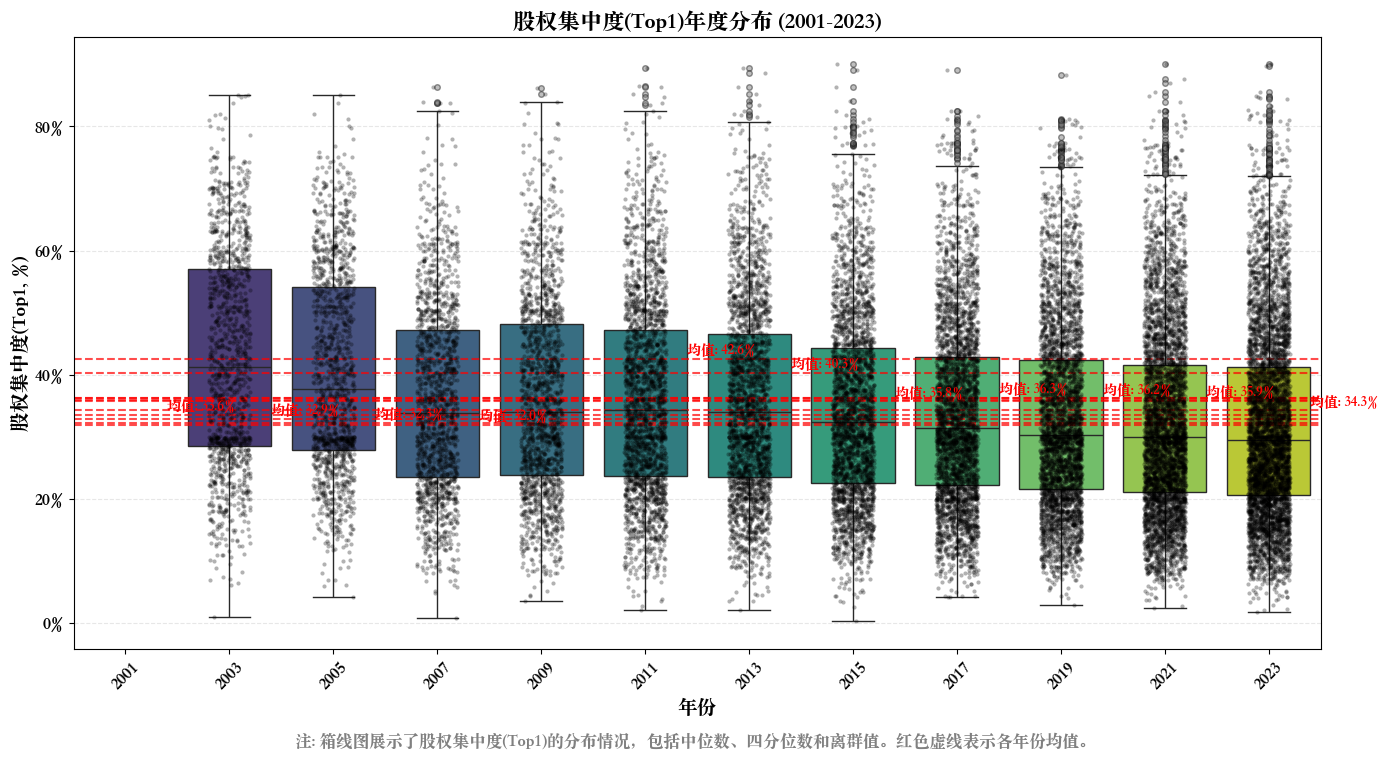


股权集中度(Top1)描述性统计:
         count    mean     std    min     25%     50%     75%     max
时间                                                                   
2001    0.0000     NaN     NaN    NaN     NaN     NaN     NaN     NaN
2003 1261.0000 42.5528 17.1819 1.0606 28.6106 41.2759 57.0763 84.9984
2005 1350.0000 40.3382 16.2244 4.2380 27.8414 37.7029 54.1632 84.9785
2007 1512.0000 35.7774 15.2386 0.8225 23.4900 33.8986 47.2268 86.2863
2009 1670.0000 36.2720 15.6566 3.6355 23.8093 33.9747 48.1963 86.2003
2011 2295.0000 36.2038 15.6702 2.1969 23.7754 34.3301 47.2724 89.4086
2013 2466.0000 35.8655 15.6545 2.1969 23.5093 33.9492 46.6042 89.4086
2015 2806.0000 34.3266 14.9910 0.2863 22.6479 32.3816 44.2865 89.9858
2017 3461.0000 33.5866 14.6139 4.1456 22.2287 31.4047 42.9266 89.0930
2019 3753.0000 32.8855 14.7056 3.0029 21.5866 30.2994 42.3374 88.2353
2021 4677.0000 32.2911 14.8858 2.4307 21.1241 29.9000 41.5480 89.9910
2023 5322.0000 31.9592 15.0034 1.8464 20.6750 29.5243 41.2309 89.9910


/var/folders/3k/c1rhghwj4xn7zh2x1sj__yt40000gn/T/ipykernel_78879/1595533376.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


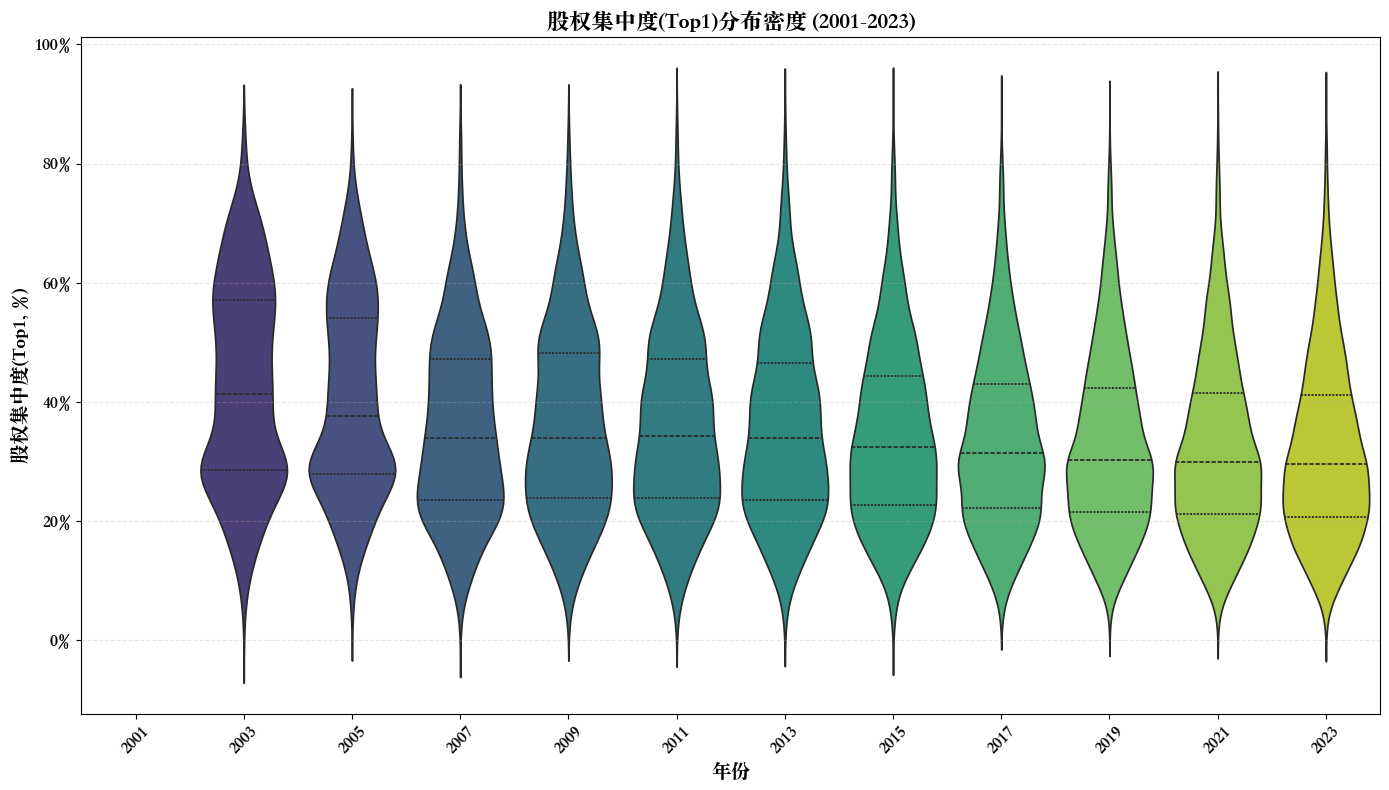


第八步处理完成!


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import os

# 设置中文字体（适用于Mac系统）
try:
    # 尝试查找 macOS 系统自带的中文字体
    font_names = ['Songti SC', 'STHeiti', 'PingFang SC', 'Hiragino Sans GB', 'Arial Unicode MS']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 寻找可用的中文字体
    chinese_font = None
    for font in font_names:
        if font in available_fonts:
            chinese_font = font
            break
    
    # 如果找到可用字体，设置matplotlib使用它
    if chinese_font:
        plt.rcParams['font.sans-serif'] = [chinese_font]
        print(f"使用中文字体: {chinese_font}")
    else:
        print("未找到系统自带中文字体，使用英文标签")
        USE_CHINESE = False
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
except:
    print("字体设置失败，使用英文标签")
    USE_CHINESE = False

# 1. 读取文件
input_path = '/Users/wanshiqing/Desktop/python_code/merged_data.xlsx'
print(f"正在读取文件: {input_path}")
df = pd.read_excel(input_path)
print(f"数据读取成功! 共 {len(df)} 行记录")

# 2. 筛选指定年份的数据
selected_years = {2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023}
print(f"\n筛选年份: {sorted(selected_years)}")

# 确保时间字段存在
if '时间' not in df.columns:
    # 尝试查找可能的替代字段
    possible_cols = [col for col in df.columns if '时间' in col or 'year' in col.lower() or 'date' in col.lower()]
    if possible_cols:
        df.rename(columns={possible_cols[0]: '时间'}, inplace=True)
        print(f"使用替代字段作为时间: {possible_cols[0]}")
    else:
        raise ValueError("无法找到时间字段")

# 筛选数据
filtered_df = df[df['时间'].isin(selected_years)].copy()
print(f"筛选后数据量: {len(filtered_df)} 行")

# 3. 检查股权集中度1字段
if '股权集中度1' not in filtered_df.columns:
    # 尝试查找可能的替代字段
    possible_cols = [col for col in filtered_df.columns if '股权集中度' in col or 'top1' in col.lower()]
    if possible_cols:
        filtered_df.rename(columns={possible_cols[0]: '股权集中度1'}, inplace=True)
        print(f"使用替代字段作为股权集中度1: {possible_cols[0]}")
    else:
        raise ValueError("无法找到股权集中度1字段")

# 重命名列以便使用
filtered_df.rename(columns={'股权集中度1': 'Top1'}, inplace=True)

# 4. 绘制箱线图
plt.figure(figsize=(14, 8))

# 使用seaborn绘制箱线图
sns.boxplot(
    x='时间', 
    y='Top1', 
    data=filtered_df,
    palette='viridis',
    showfliers=True,  # 显示离群值
    flierprops=dict(marker='o', markersize=4, markerfacecolor='gray', alpha=0.5)  # 离群点样式
)

# 添加散点图显示数据分布
sns.stripplot(
    x='时间', 
    y='Top1', 
    data=filtered_df,
    color='black',
    alpha=0.3,
    jitter=0.2,
    size=3
)

# 设置标题和标签
if 'USE_CHINESE' in globals() and not USE_CHINESE:
    plt.title('Top1 Shareholder Concentration by Year (2001-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Top1 Concentration (%)', fontsize=14)
else:
    plt.title('股权集中度(Top1)年度分布 (2001-2023)', fontsize=16)
    plt.xlabel('年份', fontsize=14)
    plt.ylabel('股权集中度(Top1, %)', fontsize=14)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

# 设置y轴为百分比格式
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# 调整x轴标签
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# 添加均值线
for year in selected_years:
    year_data = filtered_df[filtered_df['时间'] == year]['Top1']
    if not year_data.empty:
        mean_value = year_data.mean()
        plt.axhline(mean_value, color='red', linestyle='--', alpha=0.7)
        plt.text(
            list(selected_years).index(year) + 0.4, 
            mean_value + 0.5, 
            f'均值: {mean_value:.1f}%', 
            fontsize=10, 
            color='red'
        )

# 添加说明文字
plt.figtext(
    0.5, 0.01, 
    '注: 箱线图展示了股权集中度(Top1)的分布情况，包括中位数、四分位数和离群值。红色虚线表示各年份均值。',
    ha='center', 
    fontsize=12, 
    color='gray'
)

# 美化布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示图像
plt.show()

# 5. 可选：保存图像
save_option = input("\n是否保存图像? (y/n): ").strip().lower()
if save_option == 'y':
    output_path = '/Users/wanshiqing/Desktop/Top1_Concentration_Boxplot.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"图像已保存至: {output_path}")

# 6. 可选：输出描述性统计
stats = filtered_df.groupby('时间')['Top1'].describe()
print("\n股权集中度(Top1)描述性统计:")
print(stats)

# 7. 可选：绘制小提琴图
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='时间', 
    y='Top1', 
    data=filtered_df,
    palette='viridis',
    inner='quartile'
)

# 设置标题和标签
if 'USE_CHINESE' in globals() and not USE_CHINESE:
    plt.title('Top1 Shareholder Concentration Distribution by Year (2001-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Top1 Concentration (%)', fontsize=14)
else:
    plt.title('股权集中度(Top1)分布密度 (2001-2023)', fontsize=16)
    plt.xlabel('年份', fontsize=14)
    plt.ylabel('股权集中度(Top1, %)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print("\n第八步处理完成!")